In [100]:
import autograd
from autograd import numpy as np
import numpy as onp

import scipy as sp
from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline


In [50]:
# In Bishop's notation,
# sigma(x) = 1 / (1 + exp(-x)) (Bishop 10.134)
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

# To do variational logistic regression with a normal approximation, we
# need to take variational expectations wrt this term.
# log(sigma(-x)) =             (Bishop 10.148)
# log(1 / (1 + exp(x))) =
# -log(1 + exp(x))
def logit_term(x):
    return -1 * np.log1p(np.exp(x))

x = 0.2
assert(np.abs(np.log(sigmoid(-1 * x)) - logit_term(x)) < 1e-8)

In [8]:
# Let's try to integrate wrt this Gaussian.
q_mean = 0.0
q_sd = 1.0

Monte Carlo estimates with 100 samples: median -0.8054661096354745, std 0.053407723937768985


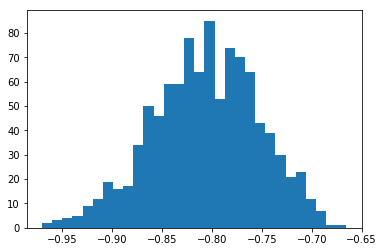

In [108]:
# Monte Carlo:
def get_monte_carlo_results(q_mean, q_sd, mc_sims, n_trials):
    x_draws = np.random.normal(loc = q_mean, scale = q_sd, size = mc_sims)    
    mc_results = []
    for trial in range(n_trials):
        x_draws = np.random.normal(loc = q_mean, scale = q_sd, size = mc_sims)
        mc_results.append(np.mean(logit_term(x_draws)))
        
    return mc_results

mc_results = get_monte_carlo_results(q_mean, q_sd, mc_sims = 100, n_trials = 1000)

hist_unused = plt.hist(mc_results, bins=30)

print('Monte Carlo estimates with {} samples: median {}, std {}'.format(
    mc_sims, np.median(mc_results), np.std(mc_results)))

Jaakola results: -2.2195773615229943


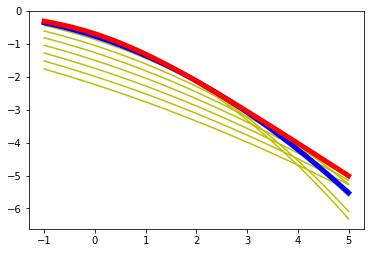

In [141]:
# Jaakola and Jordan

# In this simplified setting, we are simply taking the expectation of Bishop (10.149)
# with respect to the normal variational distribution q(x) where x = -z (Bishop's z, our x).


# Bishop (10.150)
def jaakola_lambda(xi):
    return (sigmoid(xi) - 0.5) / (2 * xi)

# The expectation of Bishop (10.149) evaluated at x = -z.
def jaakloa_expected_log_bound(ex, ex2, xi):
    return np.log(sigmoid(xi)) - 0.5 * (ex + xi) - jaakola_lambda(xi) * (ex2 - xi ** 2)

# Evaluate a single point, which is the same as evaluating the expectation
# wrt a normal with zero variance.
def jaakloa_log_bound(x, xi):
    return jaakloa_expected_log_bound(x, x ** 2, xi)

def get_jaakola_results(q_mean, q_sd):
    # E_q [x]
    eq_x = q_mean

    # E_q [x ** 2]
    eq_x2 = q_mean ** 2 + q_sd ** 2

    # No need to do the coordinate ascent updates from Bishop section 10.6.2 -- 
    # let's just optimize for xi directly.
    xi_opt_result = sp.optimize.minimize(
        fun = lambda xi: -1 * jaakloa_expected_log_bound(eq_x, eq_x2, xi),
        x0 = 1,
        method = 'Nelder-Mead')

    xi_opt = xi_opt_result.x
    jaakola_result = jaakloa_expected_log_bound(eq_x, eq_x2, xi_opt)
    
    return jaakola_result, xi_opt
    

# Doesn't look too bad!
jaakola_result, xi_opt = get_jaakola_results(q_mean, q_sd)
x_range = np.linspace(-3 * q_sd + q_mean, 3 * q_sd + q_mean, 100)
xi_range = np.linspace(0.01, 4 * xi_opt, 10)
for xi in xi_range:
    plt.plot(x_range, jaakloa_log_bound(x_range, xi), 'y')
plt.plot(x_range, jaakloa_log_bound(x_range, xi_opt), 'b', linewidth=5)
plt.plot(x_range, logit_term(x_range), 'r', linewidth=5)

print('Jaakola results: {}'.format(float(jaakola_result)))

In [112]:
# Now try plain old Gauss-Hermite quadrature.

def get_gauss_hermite_results(q_mean, q_sd, num_gh_points):
    gh_points, gh_weights = onp.polynomial.hermite.hermgauss(num_gh_points)
    gh_x = np.sqrt(2) * q_sd * gh_points + q_mean 
    return np.sum(gh_weights * logit_term(gh_x)) / np.sqrt(np.pi)

print('Gauss-Hermite result with {} points: {}'.format(num_gh_points, gh_result))

Gauss-Hermite result with 5 points: -0.8060175539093457


In [155]:
# A summary.  Play with it yourself!
q_mean = 2.0
q_sd = 4

mc_sims = 100
gh_points = 4
truth_gh_points = 100

mc_results = get_monte_carlo_results(q_mean, q_sd, mc_sims = mc_sims, n_trials = 1000)
jaakola_result, xi_opt = get_jaakola_results(q_mean, q_sd)
gh_result = get_gauss_hermite_results(q_mean, q_sd, gh_points)
gh_result_truth = get_gauss_hermite_results(q_mean, q_sd, truth_gh_points)

print('Monte Carlo median ({} draws):\t{:0.6f}, std {:0.6f}'.format(
    mc_sims, np.median(mc_results), np.std(mc_results)))
print('Jaakola results:\t\t{:0.6f}'.format(float(jaakola_result)))
print('GH result ({} points):\t\t{:0.6f}'.format(gh_points, gh_result))
print('Truth:\t\t\t\t{:0.6f}'.format(gh_result_truth))

Monte Carlo median (100 draws):	-2.938315, std 0.293752
Jaakola results:		-3.247426
GH result (4 points):		-2.925559
Truth:				-2.929045
